In [1]:
from input import read
from stats import percentage 
from viz import heatmap
from utils import time, shape, string_op
import numpy as np
from datetime import datetime
import dateutil

In [2]:
symbol = "WEED.TO"
end_date = datetime.today() #today
start_date = end_date + dateutil.relativedelta.relativedelta(months=-1) #month ago

date, num_data = read.get_data_from_web(symbol, start_date, end_date)

In [5]:
sh = np.shape(date)

days = []
for i in range (sh[0]):
#    day = time.get_day_number_from_date_string(date[i][0])
    day = time.get_day_number_from_date_string(date[i].strftime("%Y-%m-%d"))
    days.append(day)

#nd = read.get_numeric_data_from_all_data(data)
pc = percentage.get_percentage_change_from_numeric_data(num_data)
perc = pc * 100

shaped_perc = shape.reshape_data(perc, days, 5)
print shaped_perc

title = symbol + ": " + start_date.strftime("%Y-%m-%d")+ " to " + end_date.strftime("%Y-%m-%d")

[[-1.37931034 -1.66041243  4.93491839 -2.11776849 -0.83333329]
 [ 1.86818371 -5.75       -5.55556065  7.27590221 -3.22580645]
 [-0.2187042   0.69780465 -2.34541578 -0.81521739  2.75132275]
 [ 1.37475058 -0.09995002 -4.1         1.71874991 -0.40816327]]


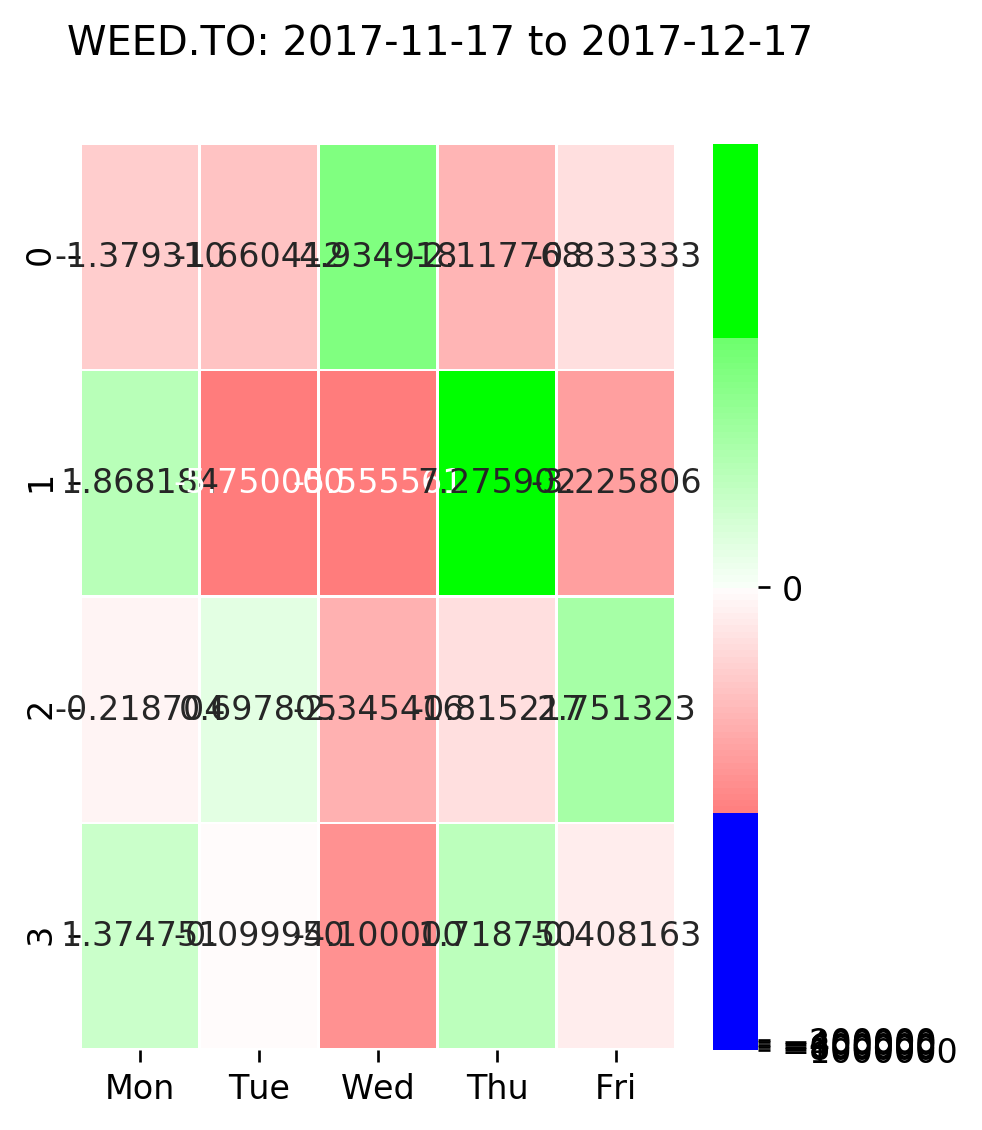

In [4]:
heatmap.show(shaped_perc, title, 5)